In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from figure_making import data_loader

In [10]:
animal_ids = ["SZ036", "SZ037", "SZ038", "SZ039", "SZ042", "SZ043"]
# animal_ids=["SZ036"]
master_df1 = data_loader.load_dataframes_for_animal_summary(animal_ids, 'nonreward_DA',
                                                            day_0='2023-11-30',
                                                            melt=1,
                                                            hemisphere_qc=1,
                                                            file_format='parquet')

animal_ids = ["RK007", "RK008"]
master_df2 = data_loader.load_dataframes_for_animal_summary(animal_ids, 'nonreward_DA',
                                                            day_0='2025-06-17',
                                                            melt=1,
                                                            hemisphere_qc=1,
                                                            file_format='parquet')
master_NR_DA_df = pd.concat([master_df1, master_df2], ignore_index=True)

C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of panda

   time_recording phase  trial port  time_in_port hemisphere        DA  \
0       18.481344   0.8    1.0  exp      0.007910       left -1.997424   
1       18.481344   0.8    1.0  exp      0.007910      right -1.945218   
2       18.505971   0.8    1.0  exp      0.032537       left -1.708472   
3       18.505971   0.8    1.0  exp      0.032537      right -1.944138   
4       18.530790   0.8    1.0  exp      0.057357       left -1.597010   

         F0 side_relative animal           session  day_relative  \
0 -1.139851        contra  SZ036  2023-12-26T17_27            26   
1 -0.384342          ipsi  SZ036  2023-12-26T17_27            26   
2 -1.139851        contra  SZ036  2023-12-26T17_27            26   
3 -0.384342          ipsi  SZ036  2023-12-26T17_27            26   
4 -1.139851        contra  SZ036  2023-12-26T17_27            26   

   session_of_day  
0               1  
1               1  
2               1  
3               1  
4               1  

Total number of data poin

C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of panda

   time_recording phase  trial port  time_in_port hemisphere        DA  \
0       40.930406   0.8    1.0  exp      0.009229       left -1.956630   
1       40.955021   0.8    1.0  exp      0.033843       left -1.917499   
2       40.979635   0.8    1.0  exp      0.058458       left -1.891818   
3       41.004480   0.8    1.0  exp      0.083303       left -1.827597   
4       41.028826   0.8    1.0  exp      0.107648       left -1.953000   

         F0 side_relative animal           session  day_relative  \
0 -0.693354          ipsi  RK007  2025-06-17T15_02             0   
1 -0.693354          ipsi  RK007  2025-06-17T15_02             0   
2 -0.693354          ipsi  RK007  2025-06-17T15_02             0   
3 -0.693354          ipsi  RK007  2025-06-17T15_02             0   
4 -0.693354          ipsi  RK007  2025-06-17T15_02             0   

   session_of_day  
0               1  
1               1  
2               1  
3               1  
4               1  

Total number of data poin

C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df_reshaped.stack(level=1)
C:\Users\shich\PycharmProjects\fiber-photometry-data-analysis\figure_making\data_loader.py:143: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of panda

In [32]:
def bin_nonreward_DA(nonreward_DA_df, bin_size=0.1):
    max_time = nonreward_DA_df['time_in_port'].max()
    bins = np.arange(0, max_time + bin_size, bin_size)
    nonreward_DA_df['time_bin'] = pd.cut(nonreward_DA_df['time_in_port'], bins=bins, include_lowest=True)

    def sem(series):
        return series.std() / np.sqrt(len(series))

    binned_results = nonreward_DA_df.groupby(['animal', 'session', 'hemisphere', 'time_bin', 'phase'], observed=True)['DA'].agg(
        ['mean', ('sem', sem)]).reset_index()
    binned_results['bin_center'] = binned_results['time_bin'].apply(lambda x: x.mid.round(2))

    return binned_results

In [33]:
grouped_df = bin_nonreward_DA(master_NR_DA_df, bin_size=0.5)

In [34]:
import matplotlib as mpl
def plot_phase_differences(binned_df, save=0):
    mpl.rcParams['figure.dpi'] = 300
    # --- 1. PRE-PROCESSING ---
    binned_df['bin_center'] = binned_df['bin_center'].astype(float)
    df = binned_df.copy()
    # df = binned_df[binned_df['bin_center'] <= 1.5].copy()
    # Pivot to get phases into columns
    df_pivot = df.pivot_table(
        index=['animal', 'session', 'hemisphere', 'bin_center'],
        columns='phase',
        values='mean'
    ).reset_index()
    # Calculate the difference (Phase 0.8 - Phase 0.4)
    df_pivot['diff'] = df_pivot['0.8'] - df_pivot['0.4']
    df_pivot = df_pivot.dropna(subset=['diff'])

    # --- 2. PLOTTING SETUP ---
    groups = df_pivot[['animal', 'hemisphere']].drop_duplicates()

    # Create a figure
    num_plots = len(groups)
    if num_plots == 0:
        print("No data found matching criteria.")
        return

    rows = 3
    cols = 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 9), squeeze=False)
    mpl.rcParams['figure.dpi'] = 300
    axes = axes.flatten() # Make axes easy to iterate over

    # --- 3. PLOTTING LOOP ---

    for i, (idx, row) in enumerate(groups.iterrows()):
        animal = row['animal']
        hemi = row['hemisphere']
        ax = axes[i]
        subset = df_pivot[(df_pivot['animal'] == animal) & (df_pivot['hemisphere'] == hemi)]
        sessions = sorted(subset['session'].unique())

        # --- GENERATE COLOR MAP ---
        colors = cm.Greys(np.linspace(0.3, 0.9, len(sessions)))

        # Plot individual sessions
        for j, session in enumerate(sessions):
            sess_data = subset[subset['session'] == session]
            ax.plot(
                sess_data['bin_center'],
                sess_data['diff'],
                color=colors[j],
                alpha=0.5,
                linewidth=1,
                label='_nolegend_'
            )

        # --- CALCULATE AND PLOT GRAND AVERAGE (RED) ---
        stats = subset.groupby('bin_center')['diff'].agg(['mean', 'sem']).reset_index()

        ax.plot(stats['bin_center'], stats['mean'], color='red', linewidth=2, label='Mean Diff')
        ax.fill_between(
            stats['bin_center'],
            stats['mean'] - stats['sem'],
            stats['mean'] + stats['sem'],
            color='red',
            alpha=0.2
        )

        # Formatting
        ax.set_title(f"{animal} - {hemi}")
        ax.set_ylim(-2, 2)
        if i >= (rows - 1) * cols: ax.set_xlabel("Time (s)")
        if i % cols == 0: ax.set_ylabel("DA Diff (High - Low)")
        ax.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero reference line
    for j in range(i + 1, len(axes)): axes[j].axis('off')
    plt.tight_layout()
    if save:
        plt.savefig('NR_rising_tide.png', dpi=300, bbox_inches='tight')
    plt.show()

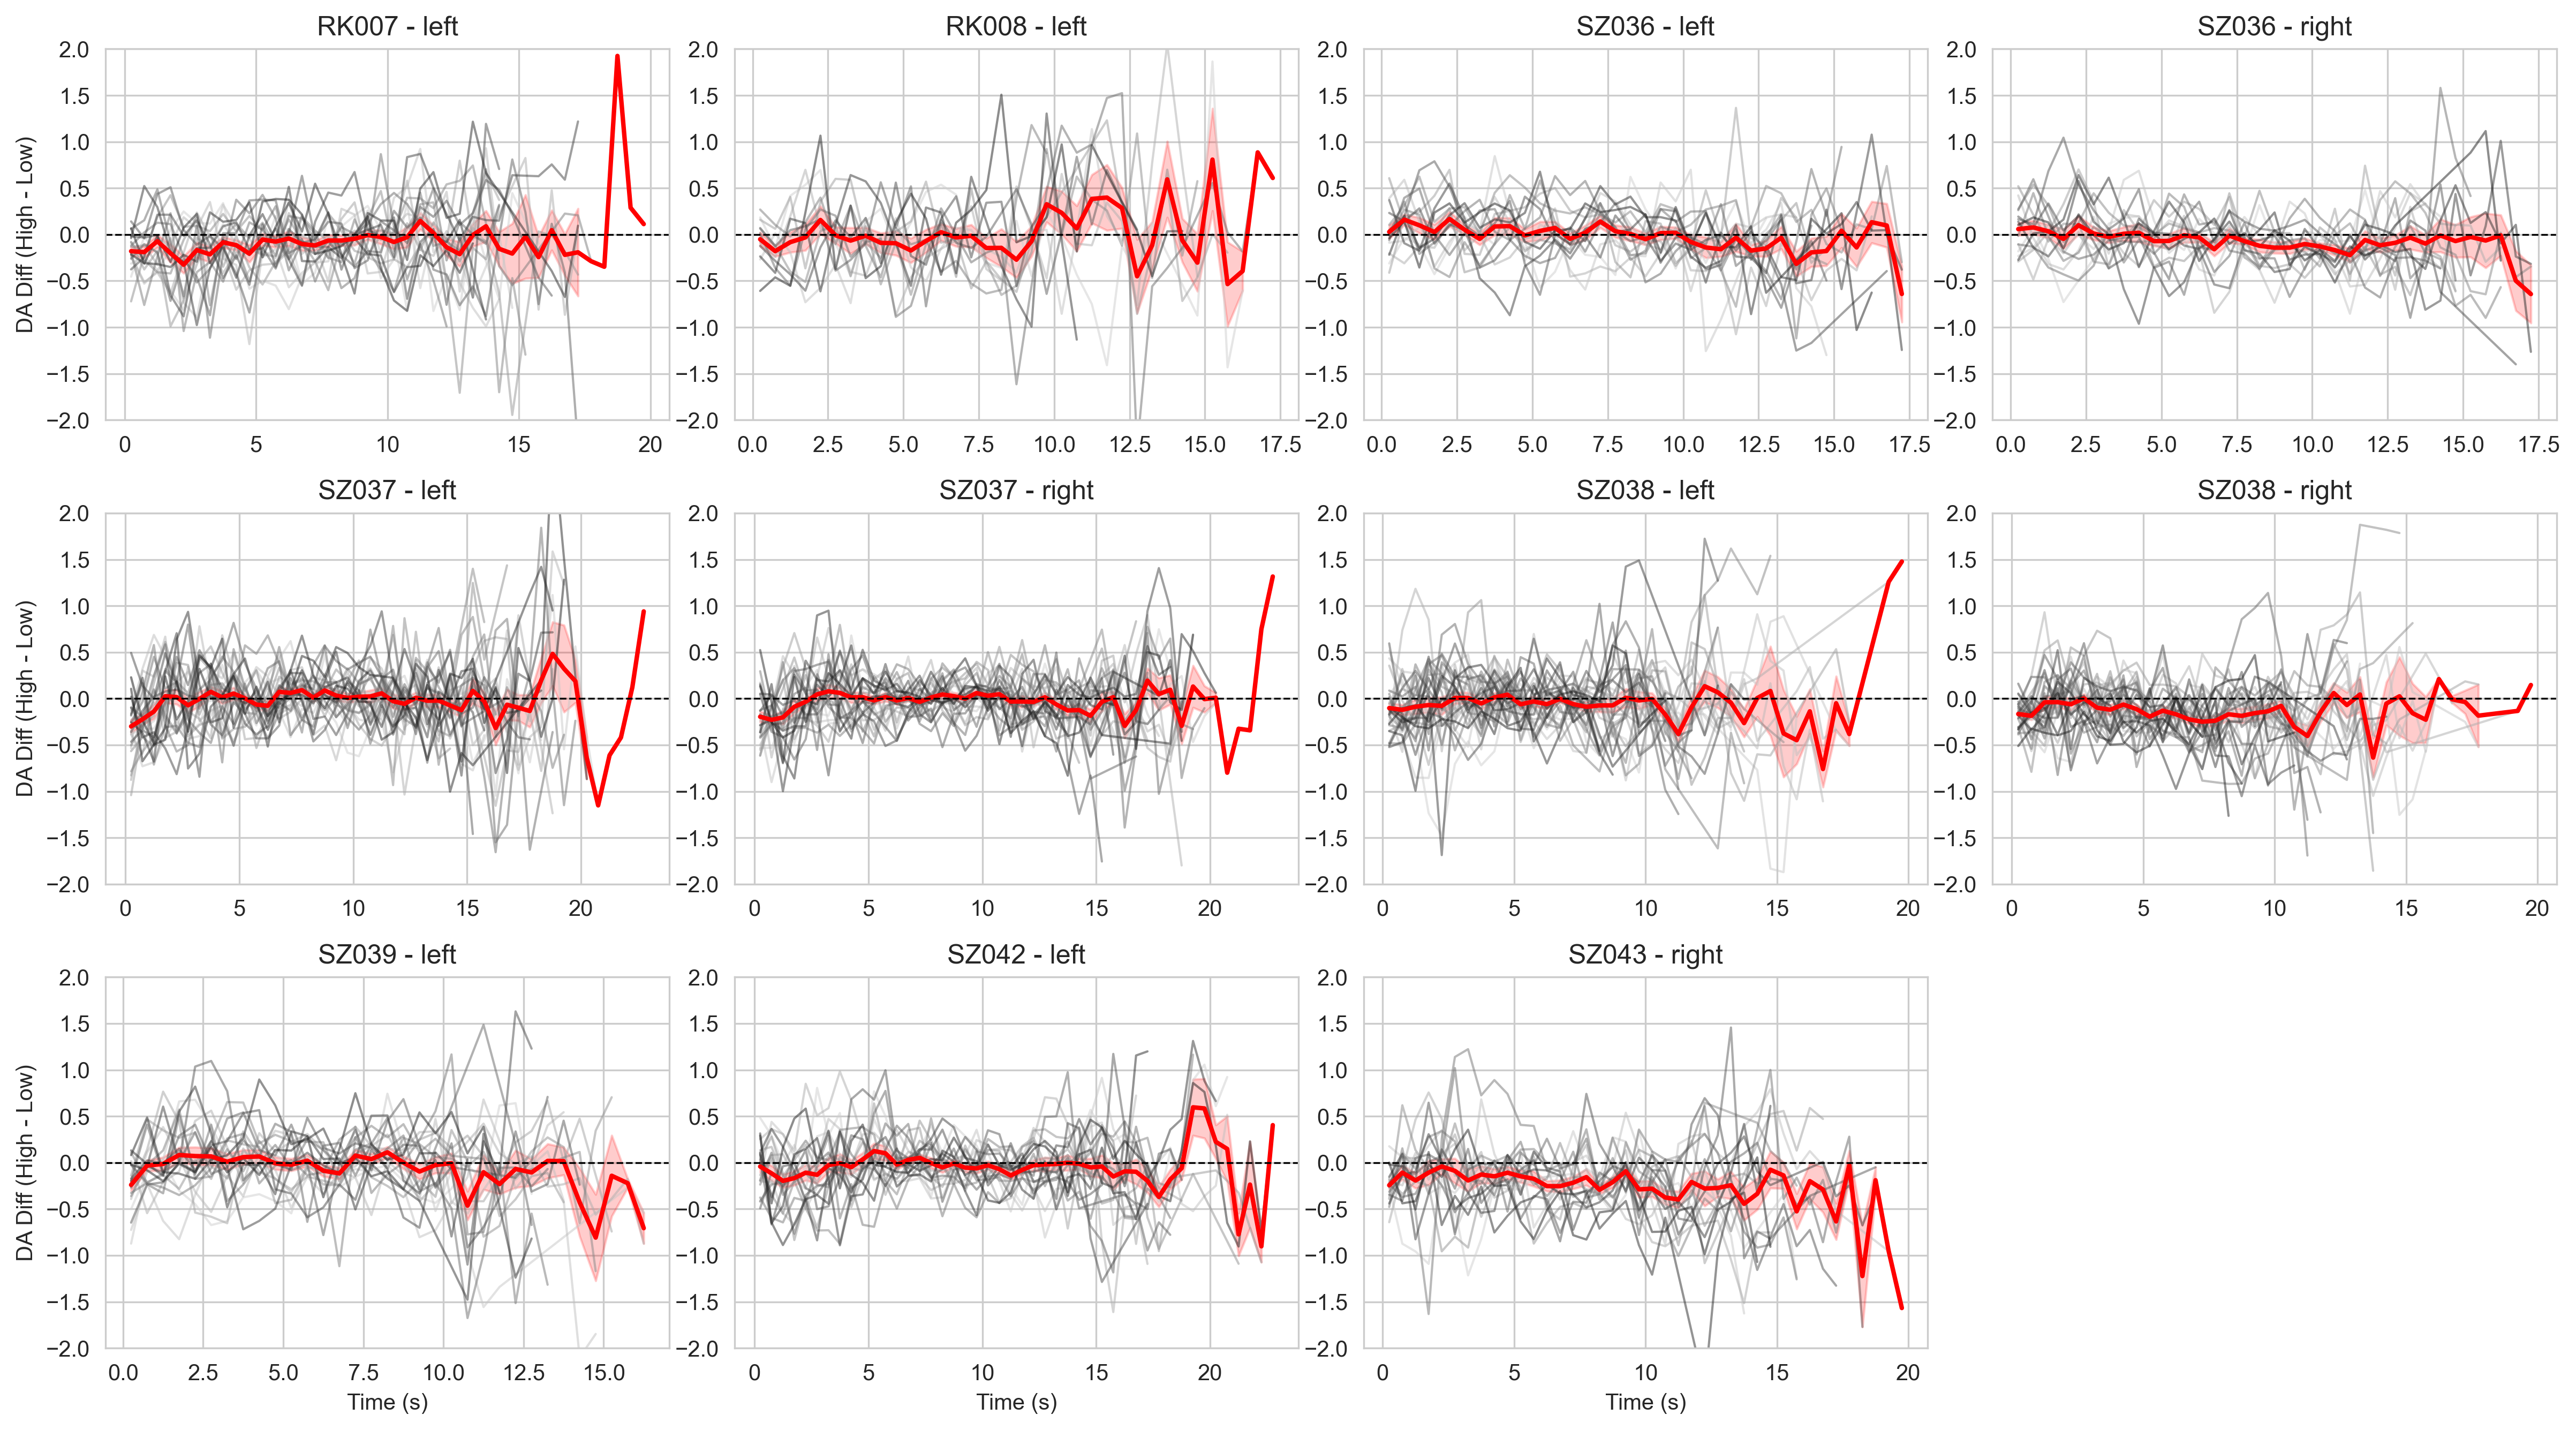

In [36]:
plot_phase_differences(grouped_df, save=1)